# Exploration and explotation methods

This notebook contains implementation and demonstration of various reinforcement learning methods focused on the exploration-exploitation trade-off problem.

1. Epsilon-Greedy
2. Optimistic Initial Values
3. Upper Confidence Bound (UCB1)
4. Thompson Sampling
5. Thompson Sampling with Gaussian Reward

In [25]:
# Libraries needed
import random as rnd
from matplotlib import pyplot as plt
from math import log
import numpy as np
from scipy.stats import beta

In [83]:
# Plot methods
def plot_bandit_balance(bandits):
    names = [i.n for i in bandits]
    n_pulls = [i.n_pulls for i in bandits]
    colors = ['#453C67', '#5B8FB9', '#E94560']
    
    fig = plt.figure(figsize=(5, 2))
    ax = fig.add_axes([0,0,1,1])
    if len(n_pulls) > 1:
        bars = ax.bar(names, n_pulls, color=colors)
    else:
        bars = ax.bar(names, n_pulls)

    # Add labels to the bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height, str(height), ha='center', va='bottom')
    
    ax.set_xlabel('Bandit machine')
    ax.set_ylabel('Number of pulls')
    ax.set_title('Number of pulls by bandit')
    plt.show()

## The multiarmed bandit problem

A multi-armed bandit is a problem in reinforcement learning where an agent must choose between multiple options (the "arms" of the "bandit"), with each option having a potentially different reward. The agent must balance exploration (trying different options to learn more about their rewards) and exploitation (choosing the option with the highest known reward) in order to maximize its overall reward.

**Class in Python to simulate a bandit machine**

In [91]:
class bandit_machine:
    """
    class to generate a bandit machine model
    """
    def __init__(self, name: str, probability: float, intial_mean: int = 0, save_history: bool = False):
        """
        Contructor to initialize a bandit machine
        :var name: name of the machine
        :var probability: probabilty to gain a reward
        :var initial_mean: initial sample mean of the machine
        :var save_history: if True saves the sample mean of every result (memory consuming)
        """
        self.n = name                               # Name of the machine
        self.p = probability                        # Probability to gain a reward
        self.n_pulls = 0                            # Number of times the arm was pulled
        self.cumulated_reward = 0                   # Total reward
        self.sample_mean = intial_mean              # Mean from the rewards given
        self.sample_mean_history = [intial_mean]    # Saves a history of all the sample means

        # Check the initial_mean
        if intial_mean > 0:
            self.n_pulls = 1

    def pull(self) -> int:
        """
        Method to simulate a result after pulling the arm from the machine
        :return: 1 if you got a reward, 0 if you didn't
        """
        reward = int(rnd.random() < self.p)
        self._update_parameters(reward)
        return reward

    def _update_parameters(self, reward):
        """
        Method
        """
        self.n_pulls += 1
        self.cumulated_reward += reward
        self.sample_mean = (self.sample_mean * (self.n_pulls-1) + reward)/self.n_pulls
        self.sample_mean_history.append(self.sample_mean)

    def get_data(self):
        """
        Method to get all the history data from the bandit machine
        """
        msg = f"""
        [{self.n} ({self.p})]
          - Arm pulled: {self.n_pulls}
          - Sample mean: {self.sample_mean}
          - Cumulated reward: {self.cumulated_reward}
        """
        print(msg)
        self._plot_sample_mean_graph()

    def _plot_sample_mean_graph(self):
        x_values = range(len(self.sample_mean_history))
        y_values = self.sample_mean_history
        plt.plot(x_values, y_values, '-')
        plt.xlabel("Iterations")
        plt.ylabel("Estimated mean")
        plt.title(f"{self.n} ({self.p})")
        plt.show()

**Creating the bandit machines**

For the following scripts, we are going to test various reinforcement learning methods on three different bandit machines. Each machine has a distinct probability of giving a reward, with one having a probability of 0.2, another 0.5, and the last one 0.75.

In [53]:
# Define the initial parameters for the three bandit machines
initial_params = {'bandit_l': 0.25, 'bandit_m': 0.5, 'bandit_h': 0.75}

# Create the bandits
bandits_test = [bandit_machine(name=n, probability=p) for n, p in initial_params.items()]

**Testing the bandit machines**

In [54]:
# Test the bandit machines
n_test_pulls = 10
samples = [[bandit.pull() for i in range(n_test_pulls)] for bandit in bandits_test]

# Print out the results
for bandit, sample in zip(bandits_test, samples):
    print(f"The {bandit.n} got this results: {sample}. Estimated mean: {bandit.sample_mean}/{bandit.p}")

The bandit_l got this results: [0, 1, 0, 0, 0, 1, 0, 0, 0, 1]. Estimated mean: 0.3/0.25
The bandit_m got this results: [0, 0, 1, 1, 1, 1, 1, 1, 0, 1]. Estimated mean: 0.7/0.5
The bandit_h got this results: [1, 1, 1, 0, 0, 1, 1, 1, 0, 1]. Estimated mean: 0.7/0.75


## 1. Epsilon Greedy method

Epsilon-Greedy method is an algorithm that balances exploration and exploitation by choosing a random action with a small probability and the greedy action with a high probability, to gather information about the environment and make better decisions over time.

**Experiment:**

In [94]:
# Creating the bandits for this experiment
bandits_greedy = [bandit_machine(name=n, probability=p, save_history=True) for n, p in initial_params.items()]

# Initial parameters
n_experiments = 500         # Number of total pulls allowed
epsilon = 0.1               # Epsilon is the probability to do a random action and explore
total_reward_greedy = 0     # Total reward of the experiment

# Run the experiments
for i in range(n_experiments):
    # Choose the bandit based on the epsilon parameter
    if rnd.random() >= 0.1:
        # Choose the best machine and exploit
        bandits_sample_mean = [m.sample_mean for m in bandits_greedy]
        j = np.argmax(bandits_sample_mean)
    else:
        # Choose a random machine and explore
        j = rnd.randint(0,len(bandits_greedy)-1)
    
    # Pull the arm of the selected machine
    total_reward_greedy += bandits_greedy[j].pull()

**Analysis:**


        [bandit_l (0.25)]
          - Arm pulled: 49
          - Sample mean: 0.3469387755102041
          - Cumulated reward: 17
        


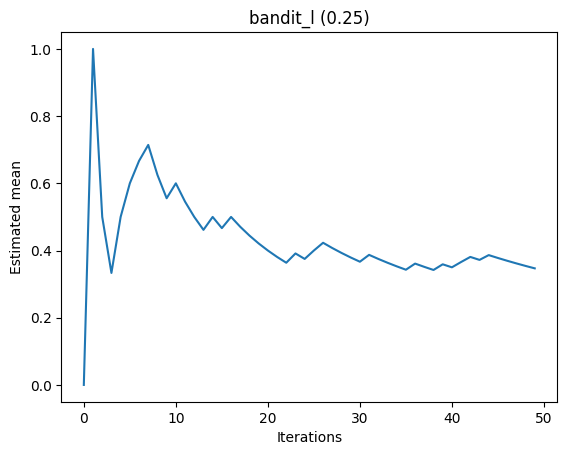


        [bandit_m (0.5)]
          - Arm pulled: 19
          - Sample mean: 0.42105263157894735
          - Cumulated reward: 8
        


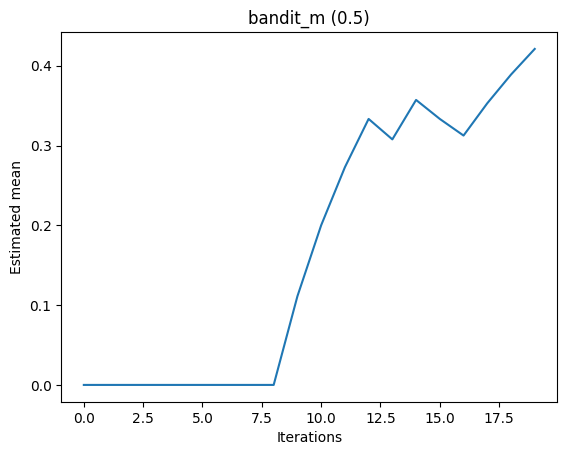


        [bandit_h (0.75)]
          - Arm pulled: 432
          - Sample mean: 0.7291666666666666
          - Cumulated reward: 315
        


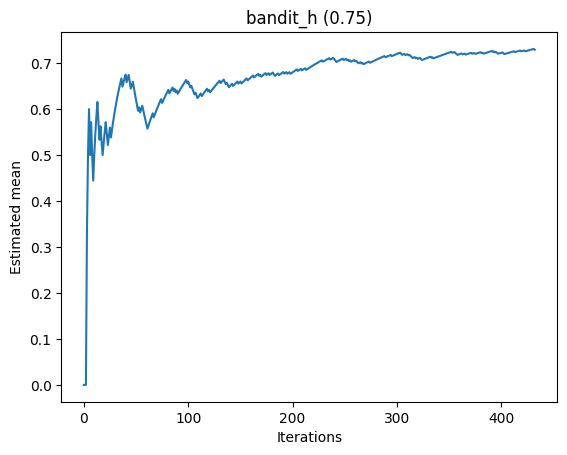

The total reward is 340 points in 500 pulls. (68.0%)


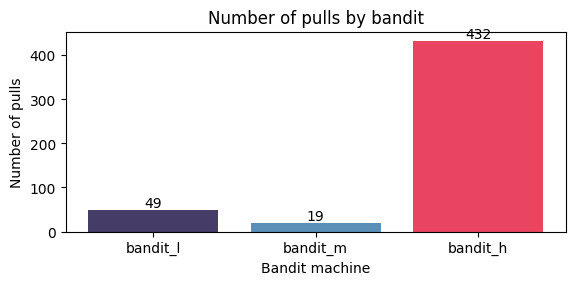

In [95]:
# Get all the data from the bandit machines
for bandit in bandits_greedy:
    bandit.get_data()


# Print the total reward
accuracy = round((total_reward_greedy/n_experiments)*100, 2)
msg = f"The total reward is {total_reward_greedy} points in {n_experiments} pulls. ({accuracy}%)"
print(msg)

# Plot a comparison of the pulls for each machine
plot_bandit_balance(bandits_greedy)

## 2. Optimistic Initial Values

Optimistic Initial Values is a method that addresses the exploration-exploitation trade-off in Multi-Armed Bandit problems by setting initial estimates of rewards higher than their actual value, leading to more exploration and faster convergence to the optimal action.

**Experiment:**

In [96]:
# Creating the bandits for this experiment
bandits_oiv = [bandit_machine(name=n, probability=p, intial_mean=2, save_history=True)\
     for n, p in initial_params.items()]

# Initial parameters
n_experiments = 500         # Number of total pulls allowed
total_reward_oiv = 0        # Total reward of the experiment

# Run the experiments
for i in range(n_experiments):
    # Choose the bandit based higher sample mean
    bandits_sample_mean = [m.sample_mean for m in bandits_oiv]
    j = np.argmax(bandits_sample_mean)
    
    # Pull the arm of the selected machine
    total_reward_oiv += bandits_oiv[j].pull()

**Analysis:**


        [bandit_l (0.25)]
          - Arm pulled: 6
          - Sample mean: 0.6666666666666666
          - Cumulated reward: 2
        


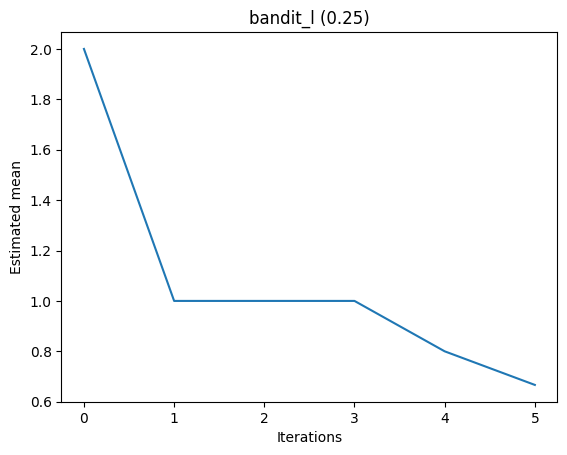


        [bandit_m (0.5)]
          - Arm pulled: 26
          - Sample mean: 0.7307692307692307
          - Cumulated reward: 17
        


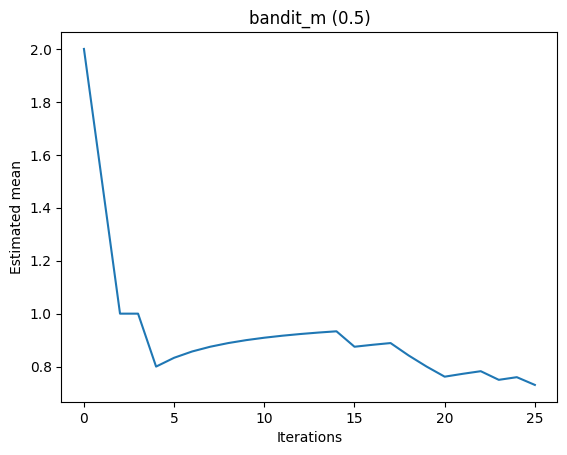


        [bandit_h (0.75)]
          - Arm pulled: 471
          - Sample mean: 0.7494692144373672
          - Cumulated reward: 351
        


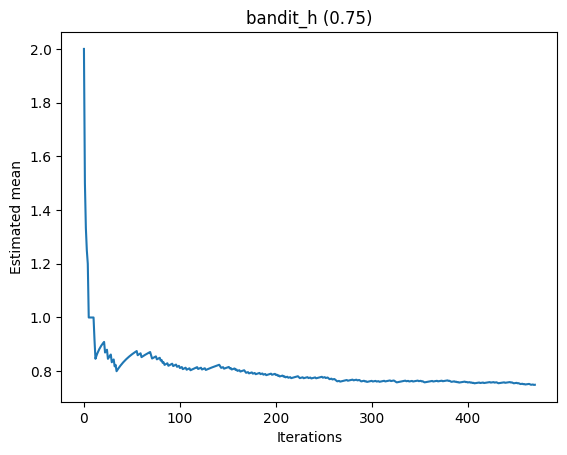

The total reward is 370 points in 500 pulls. (74.0%)


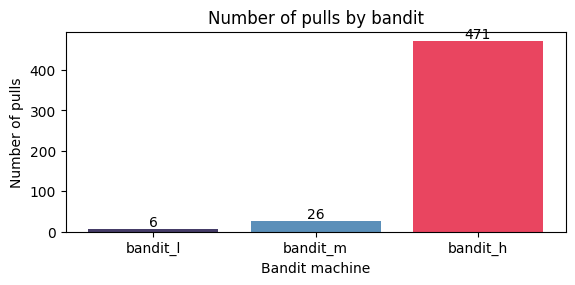

In [97]:
# Get all the data from the bandit machines
for bandit in bandits_oiv:
    bandit.get_data()


# Print the total reward
accuracy = round((total_reward_oiv/n_experiments)*100, 2)
msg = f"The total reward is {total_reward_oiv} points in {n_experiments} pulls. ({accuracy}%)"
print(msg)

# Plot a comparison of the pulls for each machine
plot_bandit_balance(bandits_oiv)

## 3. Upper Confidence Bound (UCB1)

Upper Confidence Bound (UCB1) is a method that addresses the exploration-exploitation trade-off in Multi-Armed Bandit problems by choosing actions based on the estimated potential reward and the degree of uncertainty associated with that estimate, leading to an optimal balance between exploration and exploitation.

**Experiment:**

In [ ]:
# Create the bandit machines
probabilities = [0.35, 0.5, 0.75]
machines_1 = [bandit_machine(f'machine_{i+1}', p) for i, p in enumerate(probabilities)]

# Initial parameters
n_experiments = 500
epsilon = 0.1

# Experiment
for i in range(n_experiments):
    # Select the machine to run
    best_estimation = max([m.p_estimated for m in machines_1])
    selected_machine = [m for m in machines_1 if m.p_estimated == best_estimation][0]

    # Pull the machine
    reward = selected_machine.pull()
    selected_machine.update(reward)


# Plot results
for m in machines_1:
    print(f'{m.name} ({m.n_samples} pulls):')
    print(f'The bandit has a estimated probability of {round(m.p_estimated, 2)}/{m.p}')
    x_points = list(range(len(m.p_estimated_cache)))
    plot_function(m.name, x_points, m.p_estimated_cache)

: 

In [ ]:
m_eg = machines[2]
m_ov = machines_1[2]

x_points = list(range(100))

plt.plot(x_points, m_eg.p_estimated_cache[:100], '-')
plt.plot(x_points, m_ov.p_estimated_cache[:100], '-')
plt.xlabel("Iterations")
plt.ylabel("Estimated mean")
plt.title(f"Epsilon greedy VS Optimistic initial values")
plt.show()

: 

In [ ]:
from math import log

class bandit_machine:
    """
    class to create a bandit machine object
    """
    def __init__(self, name: str, probability: float):
        """
        Contructor to initialize a bandit machine
        :var name: name of the machine
        :var probability: probabilty to gain a reward
        """
        self.name = name                # Name of the machine
        self.p = probability            # Probability to gain a reward
        self.p_estimated = 2            # Estimated probability for each iteration
        self.n_samples = 1              # Number of times we pull the arm
        self.p_estimated_cache = [self.p_estimated]    # Not need it. Only to plot the sample mean later on

    def pull(self) -> int:
        """
        Method to simulate a result after pulling the arm from the machine
        :return: 1 if you got a reward, 0 if you didn't
        """
        return int(rnd.random() < self.p)

    def update(self, x: int):
        """
        Method to update the estimated probability and number of samples parameters
        :var x: reward obtained
        """
        self.n_samples += 1
        x_mean = ((self.n_samples - 1) * self.p_estimated + x) / self.n_samples
        self.p_estimated = x_mean
        self.p_estimated_cache.append(self.p_estimated)


def apply_weight(x_mean, n_plays, n_samples):
    return x_mean + (2*log(n_plays)/n_samples)**0.5

: 

In [ ]:
# Create the bandit machines
probabilities = [0.35, 0.5, 0.75]
machines_2 = [bandit_machine(f'machine_{i+1}', p) for i, p in enumerate(probabilities)]

# Initial parameters
n_experiments = 500
epsilon = 0.1

# Experiment
for i in range(n_experiments):
    # Select the machine to run
    best_estimation = max([apply_weight(m.p_estimated, i+1, m.n_samples) for m in machines_2])
    selected_machine = [m for m in machines_2 if apply_weight(m.p_estimated, i+1, m.n_samples) == best_estimation][0]

    # Pull the machine
    reward = selected_machine.pull()
    selected_machine.update(reward)


# Plot results
for m in machines_2:
    print(f'{m.name} ({m.n_samples} pulls):')
    print(f'The bandit has a estimated probability of {round(m.p_estimated, 2)}/{m.p}')
    x_points = list(range(len(m.p_estimated_cache)))
    plot_function(m.name, x_points, m.p_estimated_cache)

: 

In [ ]:
m_eg = machines_1[2]
m_ov = machines_2[2]

x_points = list(range(100))

plt.plot(x_points, m_eg.p_estimated_cache[:100], '-')
plt.plot(x_points, m_ov.p_estimated_cache[:100], '-')
plt.xlabel("Iterations")
plt.ylabel("Estimated mean")
plt.title(f"Optimistic initial values VS UCB1")
plt.show()

: 

## Bayesian bandits

In [ ]:
import numpy as np
from scipy.stats import beta

class bandit_machine:
    """
    class to create a bandit machine object
    """
    def __init__(self, name: str, probability: float):
        """
        Contructor to initialize a bandit machine
        :var name: name of the machine
        :var probability: probabilty to gain a reward
        """
        self.name = name                # Name of the machine
        self.p = probability            # Probability to gain a reward
        self.a = 1                      # Number of positive outcomes (rewards)
        self.b = 1                      # Number of negative outcomes (failures)
        self.N = 0                      # Number of pulls (optional)

    def pull(self) -> int:
        """
        Method to simulate a result after pulling the arm from the machine
        :return: 1 if you got a reward, 0 if you didn't
        """
        return int(rnd.random() < self.p)

    def sample(self):
        """
        Method to draw a sample from Beta(a,b)
        """
        return np.random.beta(self.a, self.b)

    def update(self, x: int):
        """
        Method to update the estimated probability and number of samples parameters
        :var x: reward obtained
        """
        self.a += x
        self.b += 1 - x
        self.N += 1


def plot(machines, trial):
  x = np.linspace(0, 1, 200)
  for b in machines:
    y = beta.pdf(x, b.a, b.b)
    plt.plot(x, y, label=f"real p: {b.p:.4f}, win rate = {b.a - 1}/{b.N}")
  plt.title(f"Bandit distributions after {trial} trials")
  plt.legend()
  plt.show()

: 

In [ ]:
# Create the bandit machines
probabilities = [0.35, 0.5, 0.75]
machines = [bandit_machine(f'machine_{i+1}', p) for i, p in enumerate(probabilities)]

# Initial parameters
n_experiments = 2000
sample_points = [5,100,500,1999]
rewards = np.zeros(n_experiments)


for i in range(n_experiments):
    # Thompson sampling
    j = np.argmax([b.sample() for b in machines])

    # plot the posteriors
    if i in sample_points:
        plot(machines, i)

    # pull the arm for the bandit with the largest sample
    x = machines[j].pull()

    # update rewards
    rewards[i] = x

    # update the distribution for the bandit whose arm we just pulled
    machines[j].update(x)

# print total reward
print("total reward earned:", rewards.sum())
print("overall win rate:", rewards.sum() / n_experiments)
print("num times selected each bandit:", [b.N for b in machines])

: 